In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
import datetime as dt
import yfinance as yf
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import numpy as np
import statsmodels.api as sm
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from scipy import stats
import scipy.optimize as sco
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
print(__version__) # requires version >= 1.9.0

# For Notebooks
init_notebook_mode(connected=True)
# For offline use

cf.go_offline()

from scipy.stats.mstats import gmean

4.9.0


Ativos utilizados:

IBOV
S&P 500
OZ1D
FIXA11

Período de Análise:

01/01/2010 - 31/12/2019

Text(0, 0.5, 'price in $')

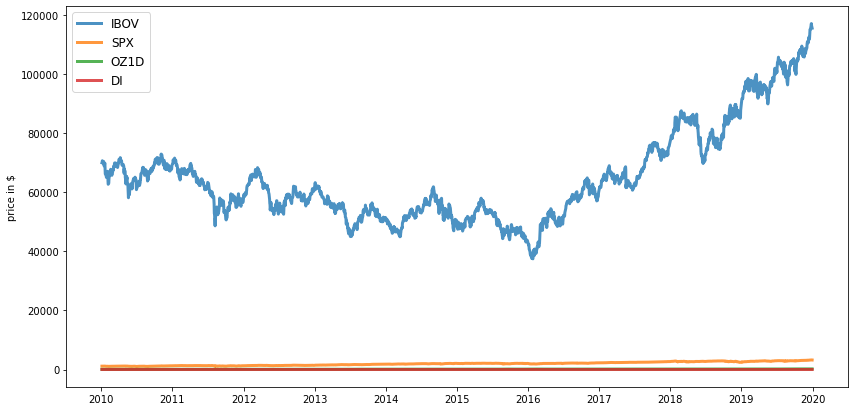

In [2]:
# Import dos ativos

ativos = pd.read_excel("ativos.xlsx")
ativos.set_index('DATA', inplace=True)

plt.figure(figsize=(14, 7))
for c in ativos:
    plt.plot(ativos.index, ativos[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [3]:
asset_returns = ativos.pct_change().dropna()
asset_returns.drop(['DI'], axis = 'columns', inplace = True)
asset_returns.head()

,IBOV,SPX,OZ1D
DATA,,,
2010-01-05,0.002780,0.003116,0.000806
2010-01-06,0.006969,0.000546,0.015310
2010-01-07,-0.003934,0.004001,0.007937
2010-01-08,-0.002674,0.002882,-0.012598
2010-01-11,0.002431,0.001747,0.022329


# Definir aqui se utiliza modelo A, G ou predições

In [4]:
vol = asset_returns.std()*np.sqrt(252)

# Média Aritmética - Modelo A
# mean_returns = (asset_returns.mean() + 1)**252 - 1

# Média Geométrica - Modelo G
# mean_returns = (gmean(asset_returns.dropna() + 1)**252 - 1)

# Predições
pl_ibov = 16.66
ret_ibov = 2**(1/pl_ibov) - 1 + 0.04

pe_spx = 36.13
ret_spx = 2**(1/pe_spx) - 1 + 0.04

exp_m2 = (162.47542/159.66767)**4 - 1
usd_hoje = 116.1253
usd_1y = 114.3423
ret_oz1d = exp_m2

meta_selic = 0.0275
ret_di = meta_selic

mean_returns = pd.Series([ret_ibov, ret_spx, ret_oz1d], index = ['IBOV', 'SPX', 'OZ1D'])
# mean_returns = pd.Series([0.051417, 0.110147, 0.125733], index = ['IBOV', 'SPX', 'OZ1D'])


print(vol,'\n')
print(mean_returns)

IBOV    0.226779
SPX     0.150992
OZ1D    0.212294
dtype: float64 

IBOV    0.082483
SPX     0.059370
OZ1D    0.072217
dtype: float64


In [5]:
# Cálculo da matriz covariância
cov_matrix = asset_returns.cov()
print(cov_matrix)
num_portfolios = 25000
risk_free_rate = 0.02

          IBOV       SPX      OZ1D
IBOV  0.000204  0.000073 -0.000043
SPX   0.000073  0.000090 -0.000027
OZ1D -0.000043 -0.000027  0.000179


In [6]:
# Função que calcula o retorno pseudo-aritmético
def pa_return(gmean_return, vol, alpha, beta):
    
    pa_r = (2 * gmean_return + alpha * vol**2)/(1 - beta * gmean_return + np.sqrt((1 + beta * gmean_return)**2 + 2 * alpha * beta * vol**2))
    
    return pa_r

print((asset_returns.mean() + 1)**252 - 1)
print(gmean(asset_returns + 1)**252 - 1)
pa_return(gmean(asset_returns + 1)**252 - 1, vol, 1, 0)

IBOV    0.082114
SPX     0.130080
OZ1D    0.159684
dtype: float64
[0.05464057 0.11725155 0.13390263]


IBOV    0.080355
SPX     0.128651
OZ1D    0.156437
dtype: float64

# Definir aqui qual modelo (alpha, beta)

In [7]:
# Função para calcular o retorno do portfólio com base em pesos aleatórios, retorna o retorno do portfólio e o desvio padrão
def portfolio(weights, mean_returns, cov_matrix):
    
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    
    # A(0,0)
    returns = np.sum(mean_returns * weights)
    
    # A(1,0)
#     returns = np.sum(mean_returns * weights) - std**2/2

    # A(1,1)
#     returns = np.sum(mean_returns * weights) - std**2/(2 * (1 + np.sum(mean_returns * weights)))
    
    # G(1,0)
#     pa_returns = [];
    
#     for i in range(len(asset_returns.columns)):
#         pa_ret = pa_return(mean_returns[i], vol[i], 1, 0)
#         pa_returns.append(pa_ret)
        
#     returns = np.sum(pa_returns * weights) - std**2 / 2
    
    # G(1,1)
#     pa_returns = [];
    
#     for i in range(len(asset_returns.columns)):
#         pa_ret = pa_return(mean_returns[i], vol[i], 1, 1)
#         pa_returns.append(pa_ret)
        
#     returns = np.sum(pa_returns * weights) - std**2 / (2 * (1 + np.sum(pa_returns * weights)))
    
    return std, returns


# Função que gera pesos aleatórios para o portfólio
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    
    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(len(asset_returns.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        portfolio_std_dev, portfolio_return = portfolio(weights, mean_returns, cov_matrix)
        
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    return results, weights_record

In [8]:
# Função que plota o resultado da simulação, indicando portfólios com max sharpe e min vol
def display_simulated_ef_with_random(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=asset_returns.columns,columns=['allocation'])
#     max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=asset_returns.columns,columns=['allocation'])
#     min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(round(max_sharpe_allocation*100,2))
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(round(min_vol_allocation*100,2))
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='.',color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='.',color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [9]:
# display_simulated_ef_with_random(num_portfolios,mean_returns,cov_matrix,risk_free_rate)

In [10]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [11]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    
    p_var, p_ret = portfolio(weights, mean_returns, cov_matrix)
    
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [12]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    
    return portfolio(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):

    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [13]:
def efficient_return(mean_returns, cov_matrix, target):
    
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        
        return portfolio(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    
    return efficients

In [14]:
# Função que mostra em vermelho a fronteira eficiente da simulação
def display_calculated_ef_with_random(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=asset_returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=asset_returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='.',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='.',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, results[1].max(), 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-', color='r', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
    return results[1].max(), rp, sdp, max_sharpe_allocation

In [15]:
# max_return = display_calculated_ef_with_random(num_portfolios,mean_returns,cov_matrix,risk_free_rate);

In [16]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=asset_returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=asset_returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = vol
    an_rt = mean_returns
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,4))
    print("Annualised Volatility:", round(sdp,4))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,4))
    print("Annualised Volatility:", round(sdp_min,4))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(asset_returns.columns):
        print(txt,":","annualised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(asset_returns.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, max_return, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-', color='r', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

In [17]:
# display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0707
Annualised Volatility: 0.1119


             IBOV    SPX   OZ1D
allocation  26.61  33.24  40.15
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0666
Annualised Volatility: 0.1074


             IBOV    SPX   OZ1D
allocation  11.29  52.37  36.34


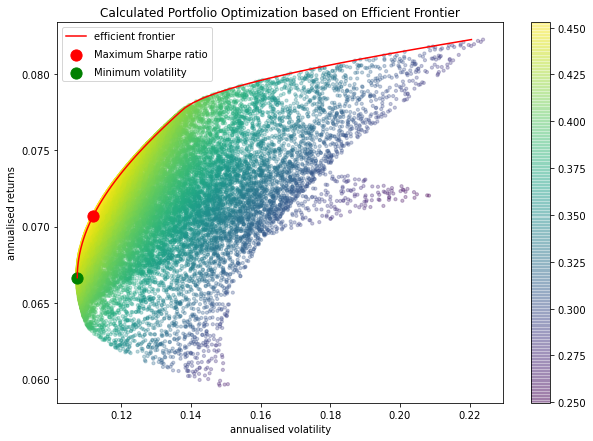

In [18]:
# Esse comando mostra o resultado da simulação, com a fronteira eficiente e indicando os portfólios com max sharpe e min vol
max_return, opt_ret, opt_vol, max_sharpe_allocation = display_calculated_ef_with_random(num_portfolios,mean_returns,cov_matrix,risk_free_rate);

## A seção de código abaixo calcula o retorno do portfólio com máximo sharpe para diferentes níveis de alocação em cash

In [19]:
opt_portfolio = [opt_ret, opt_vol]

In [20]:
# Parameters

N = 100

return1 = np.zeros((N,2))

space = np.linspace(0,1,N)

# Assets

asset1 = opt_portfolio
asset2 = [0.02, 0]

# Simulation

k = 0

for i in space:
    return1[k,0] = i*asset1[0] + (1-i)*asset2[0]
    return1[k,1] = np.sqrt((i*asset1[1])**2 + ((1-i)*asset2[1])**2)
    
    k += 1


# Plots

df1 = pd.DataFrame(columns = ['Retorno', 'Vol'])

df1['Retorno'] = return1[:,0]
df1['Vol'] = return1[:,1]

df1.iplot(kind='line',x='Vol',y=['Retorno'],mode='markers',size=5,title='Portfólio com Cash',xTitle='Volatilidade',yTitle='Retorno')

# Cálculo do Kelly Criterion para cada ponderação do portfólio com cash

In [21]:
# Kelly Criterion

kc = np.zeros(N)

for i in range(len(return1)):
    kc[i] = (return1[i,0] - 0.02) / return1[i,1]**2 * 1/4

print(kc)
kelly = pd.DataFrame(columns = ['Kelly Leverage'])
kelly['Kelly Leverage'] = kc
kelly.dropna(inplace = True)

[         nan 100.15961928  50.07980964  33.38653976  25.03990482
  20.03192386  16.69326988  14.30851704  12.51995241  11.12884659
  10.01596193   9.10541993   8.34663494   7.7045861    7.15425852
   6.67730795   6.2599762    5.89174231   5.56442329   5.27155891
   5.00798096   4.76950568   4.55270997   4.35476606   4.17331747
   4.00638477   3.85229305   3.70961553   3.57712926   3.45377998
   3.33865398   3.23095546   3.1299881    3.03513998   2.94587116
   2.86170341   2.78221165   2.70701674   2.63577945   2.56819537
   2.50399048   2.44291754   2.38475284   2.32929347   2.27635498
   2.22576932   2.17738303   2.13105573   2.08665873   2.04407386
   2.00319239   1.9639141    1.92614652   1.88980414   1.85480776
   1.82108399   1.78856463   1.7571863    1.72688999   1.69762067
   1.66932699   1.64196097   1.61547773   1.58983523   1.56499405
   1.54091722   1.51756999   1.49491969   1.47293558   1.45158869
   1.4308517    1.41069886   1.39110582   1.37204958   1.35350837
   1.33546

In [22]:
kelly.iplot(kind='line',mode='markers',size=5,title='Fator de Kelly x Percentual em Risco',xTitle='Percentual do Portfólio em Ativos de Risco',yTitle='Fator de Kelly')

In [23]:
# Fator de Kelly para diferentes pesos de portfólio x cash
print(return1[99,])
print(kc[1])
print(kc[10])
print(kc[25])
print(kc[50])
print(kc[75])
print(kc[99])

[0.07067816 0.11190556]
100.1596192787681
10.015961927876761
4.006384771150702
2.003192385575352
1.3354615903835676
1.0117133260481577
